In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.gridspec as gridspec
from pylab import *
from sklearn.feature_selection import f_regression, mutual_info_regression
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import xarray as xr

In [3]:
def cons_count_rever(df,var,count):
    df_copy = pd.concat([df,(df[var].notnull().astype(int)
            .groupby(df[var].isnull().astype(int).cumsum())
            .cumsum().to_frame(count))], axis=1)
    
    df_m24 = df_copy[df_copy['consec_count']>=24] 
    index_24 = df_copy[df_copy['consec_count']==24].index
    
    df_p24 = pd.DataFrame()
    for i in range(len(index_24)):
        z = df.loc[(index_24 - pd.Timedelta(23,unit='h')).strftime('%Y-%m-%d %X')[i] : 
                    index_24.strftime('%Y-%m-%d %X')[i]]
        df_p24 = df_p24.append(z, ignore_index=False)
    dates = pd.concat([df_m24, df_p24], axis=1).index
    
    df_fin = df[df.index.isin(dates)]

    return(df_fin)

def sel_data(ds_tcwv,dates):
    datasets = {'TCWV':[]}
    for i,date in enumerate(dates):
        datasets['TCWV'].append(ds_tcwv.tcwv.loc[date[0:10]])
    ###Means
    #TCWV
    tcwv_dat = xr.concat(datasets['TCWV'], dim='time')
    return(tcwv_dat)

def sel_season(data,sta,med,end):
    tmp = data[data.index.month.isin([sta,med,end])]
    new_df = tmp.index.strftime('%Y-%m-%d %H:%M:%S').values
    return(new_df)

def is_jja(month):
    return (month >= 6) & (month <= 8)


In [4]:
###Read Datasets and convert them!
#Path
latitud = '2-9' # 2-9 3-10 3S-4N 1p5S-8p5S
longitud = '135-145' # 135-145 147-157 156-166 163-173
path = '/Users/Casi94/Documents/PhD/Thesis/NN_real/Area_'+latitud+'_'+longitud+'_ERA5/'
#Data
tcwv = xr.open_dataset(path+'TCWV_area.nc')
#Dates
dates_rev = pd.read_csv(path+'Dates_'+latitud+'_'+longitud+'_reversals.csv', parse_dates = True, index_col = 0)
dates_org = pd.read_csv(path+'Dates_'+latitud+'_'+longitud+'_organised.csv', parse_dates = True, index_col = 0)

#Sel Dates for states
dat_org = sel_season(dates_org,3,4,5)
dat_rev = sel_season(dates_rev,3,4,5)
#Sel JJA
tcwv_jja = tcwv.sel(time=is_jja(tcwv['time.month']))

In [5]:
dates = [dat_rev, dat_org]
names = ['TCWV_Rev','TCWV_Org']
data = {}
for i,date in enumerate(dates):
    print('Calculating: '+names[i])
    data[names[i]] = sel_data(tcwv,date)

Calculating: TCWV_Rev
Calculating: TCWV_Org


In [6]:
#Substract min from max
rev_max_min = data['TCWV_Rev'].max(dim=['latitude','longitude'])  - data['TCWV_Rev'].min(dim=['latitude','longitude'])
org_max_min = data['TCWV_Org'].max(dim=['latitude','longitude'])  - data['TCWV_Org'].min(dim=['latitude','longitude'])
jja_max_min = tcwv_jja.tcwv.max(dim=['latitude','longitude'])  - tcwv_jja.tcwv.min(dim=['latitude','longitude'])

In [7]:
bins = np.arange(5,51,5)
rev_mfreq, rev_medges = np.histogram(rev_max_min, bins=bins, density=True)
org_mfreq, org_medges = np.histogram(org_max_min, bins=bins, density=True)
jja_mfreq, jja_medges = np.histogram(jja_max_min, bins=bins, density=True)

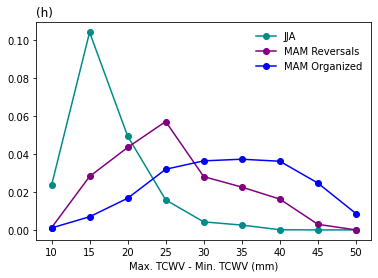

In [8]:
plt.figure(figsize=(6,4))
plt.plot(jja_medges[1:],jja_mfreq, '-o', label='JJA', color = 'darkcyan')
plt.plot(rev_medges[1:],rev_mfreq, '-o', label='MAM Reversals', color = 'purple')
plt.plot(org_medges[1:],org_mfreq, '-o', label='MAM Organized', color = 'blue')
plt.legend(frameon=False, ncol=1)
plt.xlabel('Max. TCWV - Min. TCWV (mm)')
plt.title('(h)', loc = 'left')
plt.savefig(path+'pdf_max_min.jpg', bbox_inches='tight')

In [9]:
bins = np.arange(30,81,5)
rev_freq, rev_edges = np.histogram(data['TCWV_Rev'], bins=bins,density=True)
org_freq, org_edges = np.histogram(data['TCWV_Org'], bins=bins,density=True)
jja_freq, jja_edges = np.histogram(tcwv_jja.tcwv, bins=bins,density=True)

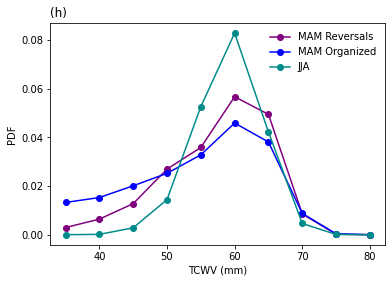

In [16]:
plt.figure(figsize=(6,4.08))
plt.plot(rev_edges[1:],rev_freq, '-o', label='MAM Reversals', color = 'purple')
plt.plot(org_edges[1:],org_freq, '-o', label='MAM Organized', color = 'blue')
plt.plot(jja_edges[1:],jja_freq, '-o', label='JJA', color = 'darkcyan')
plt.legend(frameon=False, ncol=1)
plt.xlabel('TCWV (mm)')
plt.ylabel('PDF')
plt.title('(h)', loc = 'left')
plt.savefig(path+'pdf_org_rev.jpg', bbox_inches='tight')